In [13]:
import numpy as np
import pandas as pd

In [14]:
dataset = pd.read_csv('q3.csv')

In [16]:
train = dataset

In [17]:
def computePriors(Y, dict_Y):
    '''
        Calculate P(Ci) i.e. probability of class/label i
    '''
    
    unique, counts = np.unique(Y, return_counts=True)
    
    dict_Y['True'] = counts[1] / len(Y)
    dict_Y['False'] = counts[0] / len(Y)

In [18]:
def computePosterior_category(data, feature_name, dict_X, Y):
    '''
        Calculate Posteriors : P(feature_name = val| is spam = True) and P(feature_name = val| is spam = False)
        for each val in values for feature_name
    '''
    
    values = list(data[feature_name].unique())
    unique, counts = np.unique(Y, return_counts=True)
    
    for val in values:
        set_reqd = data[data[feature_name] == val]
        
        # For spam true
        key = feature_name + ', %s' % val + ', spam, True'
        dict_X[key] = len(set_reqd[set_reqd[' is spam'] == True]) / counts[1]
        
        # For spam false
        key = feature_name + ', %s' % val + ', spam, False'
        dict_X[key] = len(set_reqd[set_reqd[' is spam'] == False]) / counts[0]

In [35]:
def gaussian(x, means, std_devs, feature, label):
    '''
        Calculates g(x, mean, std_dev) = ((sq_root(2 * pi) * (std_dev)^2)^-1) * exp(-1 * (x - mean)^2 / 2 * std_dev^2)
    '''
    # If prior calculation then label will be '' so key would be only feature name
    if label != '':
        key = feature + ',' + str(label)
    else:
        key = feature
    mean = means[key]
    std_dev = std_devs[key]
    
    exp_value = np.exp((-1 * np.square(x - mean)) / (2 * np.square(std_dev)))
    
    coefficient = np.power( (np.sqrt(2 * np.pi) * std_dev), -1 )
    
    return coefficient * exp_value

In [20]:
def computePosterior_contus(data_train, feature_name, x, label, means, std_devs):
    '''
        Calculate Posterior for continuous : P(feature_name = x| is spam = label)
    '''
    
    return gaussian(x=x, means=means, std_devs=std_devs, feature=feature_name, label=label)

In [21]:
def computeFeature_Likelihood(data_train, feature_name, dict_X):
    '''
        Calculate P(feature_name = x) and store in a dictionary
    '''
    # We will use gaussian function for probability of contus features later
    set_feature = data_train.drop([' # sentences', ' # words'], axis=1)
    
    for x in list(set_feature[feature_name].unique()):
        key = feature_name + ', %s' % x
        dict_X[key] = len(set_feature[set_feature[feature_name] == x]) / len(set_feature[feature_name])

In [67]:
def filter_features(train_X, features, dict_X, means, std_devs):
    '''
        Filters features based on gini index (We need probabilities so cannot do it for continuous)
        Gini = summation((probability for each value and class pair) ^ 2)
    '''
    gini = {}
    for feature in features:
        # For each class one value of probability
        prob = 0
        if type(train_X[feature][0]) != np.int64:
            prob += np.square(dict_X['%s, True, spam, True' % feature])
            prob += np.square(dict_X['%s, False, spam, True' % feature])
            prob += np.square(dict_X['%s, True, spam, True' % feature])
            prob += np.square(dict_X['%s, False, spam, True' % feature])
            
            gini[feature] = prob
            
    return gini

In [80]:
train_X = train.drop(' is spam', axis=1)
train_Y = train[' is spam']

dict_Y = {}
computePriors(Y=train_Y, dict_Y=dict_Y)
#print(dict_Y)

features = train_X.columns.values

# Keys are of type 'feature, value, spam, label' or 'feature, value'
dict_X = {}

# Keys are of type 'feature, value, spam, label' or 'feature, value'
means = {}
std_devs = {}

for feature in features:
    # If it has int values then continous else not
    if type(train_X[feature][0]) != np.int64:
        computePosterior_category(data=train, feature_name=feature, dict_X=dict_X, Y=train_Y)
        # Compute probabilities of feature values
        computeFeature_Likelihood(data_train=train_X, feature_name=feature, dict_X=dict_X)
    else:
        # For each class
        means[feature + ',' + str(True)] = np.mean(train[train[' is spam'] == True][feature])
        means[feature + ',' + str(False)] = np.mean(train[train[' is spam'] == False][feature])
        std_devs[feature + ',' + str(True)] = np.std(train[train[' is spam'] == True][feature])
        std_devs[feature + ',' + str(False)] = np.std(train[train[' is spam'] == False][feature])
        
        # For whole set
        means[feature] = np.mean(train_X[feature])
        std_devs[feature] = np.std(train_X[feature])
        
gini = filter_features(train_X=train_X, features=features, dict_X=dict_X, means=means, std_devs=std_devs)

features = list(features)

for feature in features:
    if type(train_X[feature][0]) != np.int64 and gini[feature] < 1.2:
        features.remove(feature)
        
features

['in html',
 ' has emoji',
 ' sent to list',
 ' from .com',
 ' has sig',
 ' # sentences',
 ' # words']

In [81]:
test_data = pd.read_csv('q3b.csv')

In [82]:
def testing(train_set, dictionaryX, dictionaryY, means, std_devs, test_data, row_index, filtered_features):
    '''
        Compute P(Y|feature_values) for test data i.e. a single row from test set
    '''
    
    # Ignore continuous for now
    test_matrix = test_data#.drop([' # sentences', ' # words'], axis=1)
    
    test_X = test_matrix.drop(' is spam', axis=1)
    test_Y = test_matrix[' is spam']
    
    # Calculate 
    # P(features|label) = multiplier(P(feature_value|label)) and 
    # P(feature set value) = multiplier(P(feature_value))
    x_given_true = 1
    x_given_false = 1
    
    x_probability = 1
    for feature in filtered_features:
        val = test_X[feature][row_index]
        
        # For continuous we calculate else we have the value in dictionary of P(feature_value|label)
        if type(val) == np.int64:
            x_given_true *= computePosterior_contus(data_train=train_set, feature_name=feature, x=val, label=True, means=means, std_devs=std_devs)
            x_given_false *= computePosterior_contus(data_train=train_set, feature_name=feature, x=val, label=False, means=means, std_devs=std_devs)
        
            # For continuous we calculate gaussian function value for P(feature_values), label ='' since full set calculation
            x_probability *= gaussian(x=val, means=means, std_devs=std_devs, feature=feature, label='')
        else:
            key = feature + ', %s' % val + ', spam, True'
            x_given_true *= dictionaryX[key]
            
            key = feature + ', %s' % val + ', spam, False'
            x_given_false *= dictionaryX[key]
        
            # P(feature_values)
            key = feature + ', %s' % val
            x_probability *= dictionaryX[key]
    
    false_given_features = x_given_false * dictionaryY['False'] / x_probability
    true_given_features = x_given_true * dictionaryY['True'] / x_probability
    
    return false_given_features, true_given_features

In [189]:
frame = pd.DataFrame(test_data.iloc[1])
np.transpose(frame)

,in html,has emoji,sent to list,from .com,has my name,has sig,# sentences,# words,is spam
1,True,False,False,True,True,False,7,87,False


In [84]:
predictions = []
for test_index in range(0, len(test_data)):
    test_frame = pd.DataFrame(test_data.iloc[test_index])
    false_prob, true_prob = testing(train_set=train, dictionaryX=dict_X, dictionaryY=dict_Y, means=means, std_devs=std_devs, test_data=np.transpose(test_frame), row_index=test_index, filtered_features=features)
    
    if false_prob > true_prob:
        predictions.append(False)
    else:
        predictions.append(True)
        
np.mean(predictions == test_data[' is spam'])
    

0.89

In [86]:
predictions = []
for test_index in range(0, len(train)):
    test_frame = pd.DataFrame(train.iloc[test_index])
    false_prob, true_prob = testing(train_set=train, dictionaryX=dict_X, dictionaryY=dict_Y, means=means, std_devs=std_devs, test_data=np.transpose(test_frame), row_index=test_index, filtered_features=features)
    
    if false_prob > true_prob:
        predictions.append(False)
    else:
        predictions.append(True)
        
np.mean(predictions == train[' is spam'])

0.898

In [64]:
dict_X

{'in html, False, spam, True': 0.2441860465116279,
 'in html, False, spam, False': 0.41304347826086957,
 'in html, True, spam, True': 0.7558139534883721,
 'in html, True, spam, False': 0.5869565217391305,
 'in html, False': 0.384,
 'in html, True': 0.616,
 ' has emoji, False, spam, True': 0.8023255813953488,
 ' has emoji, False, spam, False': 0.8526570048309179,
 ' has emoji, True, spam, True': 0.19767441860465115,
 ' has emoji, True, spam, False': 0.1473429951690821,
 ' has emoji, False': 0.844,
 ' has emoji, True': 0.156,
 ' sent to list, True, spam, True': 0.06976744186046512,
 ' sent to list, True, spam, False': 0.3115942028985507,
 ' sent to list, False, spam, True': 0.9302325581395349,
 ' sent to list, False, spam, False': 0.6884057971014492,
 ' sent to list, True': 0.27,
 ' sent to list, False': 0.73,
 ' from .com, True, spam, True': 0.7441860465116279,
 ' from .com, True, spam, False': 0.2753623188405797,
 ' from .com, False, spam, True': 0.2558139534883721,
 ' from .com, False

In [137]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  5.,  14.,  56., 135., 247., 252., 181.,  88.,  20.,   2.]),
 array([-3.6087594 , -2.91405252, -2.21934563, -1.52463874, -0.82993185,
        -0.13522496,  0.55948192,  1.25418881,  1.9488957 ,  2.64360259,
         3.33830948]),
 <a list of 10 Patch objects>)

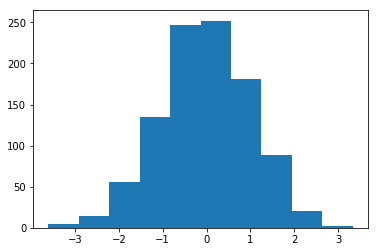

In [144]:
plt.hist(np.random.normal(0, 1, 1000))

In [142]:
np.random.normal(0, 1, 100)

array([ 0.40977574,  0.19636508,  0.20353874, -0.4622873 , -0.98678445,
       -1.75366159,  0.33636396,  0.18734605, -0.80418104,  0.58242169,
       -0.98403698,  0.70381881, -0.61714542, -0.71394945, -2.10271478,
        0.51729044, -0.37586514, -1.91293387,  0.66289186, -1.6206556 ,
       -0.10135047,  0.13690744, -0.51215987,  1.0241143 , -0.69134375,
       -0.02923648,  0.13410608, -1.49875785,  0.85555071, -0.43952665,
       -2.32953989, -0.71543042, -1.05907464,  0.02771831, -0.09454283,
       -1.31695547, -1.3824216 , -0.61848801, -0.61595022, -1.04007836,
        0.87501878,  1.15715163, -0.01710227,  1.58309311,  0.14109757,
        0.95057107,  0.25128356, -0.26884802, -2.37612269, -0.08366743,
       -0.99951599, -0.2708276 ,  0.42004774, -0.68927978,  1.67250863,
       -0.75258435,  0.22734553,  0.71410213, -0.56388747,  0.2578056 ,
        1.48395498,  0.81709274,  0.28083699, -0.82899877,  0.22433986,
        0.15746052, -0.87170695, -1.79457296,  0.71648323,  0.11